In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch


In [2]:
train = np.load("../data/train_ensemble.npy")
test  = np.load("../data/test_history.npy")

mean = np.load("../configs/mean.npy")
std  = np.load("../configs/std.npy")

train_norm = (train - mean) / std
test_norm  = (test - mean) / std


In [3]:
# ΔX = X(t+1) - X(t)
dx = train_norm[:, 1:, :] - train_norm[:, :-1, :]

noise_std = dx.std(axis=(0,1))
noise_std


array([0.03179618, 0.03180638, 0.03177692, 0.03175896, 0.03176363,
       0.0318037 , 0.03177607, 0.03178588, 0.03176985, 0.03173616,
       0.03178261])

In [4]:
def persistence_rollout(x0, steps, noise_std):
    x = x0.copy()
    traj = [x]

    for _ in range(steps):
        noise = np.random.randn(*x.shape) * noise_std
        x = x + noise
        traj.append(x)

    return np.stack(traj)


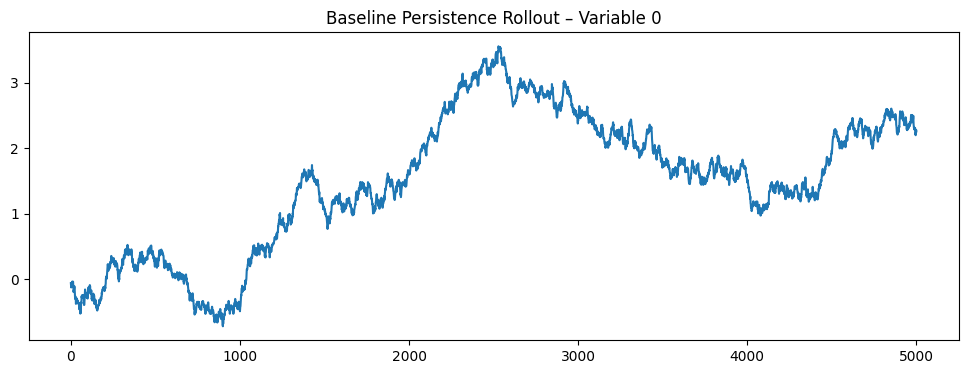

In [5]:
x0 = train_norm[0, -1]
traj = persistence_rollout(x0, steps=5000, noise_std=noise_std)

plt.figure(figsize=(12,4))
plt.plot(traj[:,0])
plt.title("Baseline Persistence Rollout – Variable 0")
plt.show()


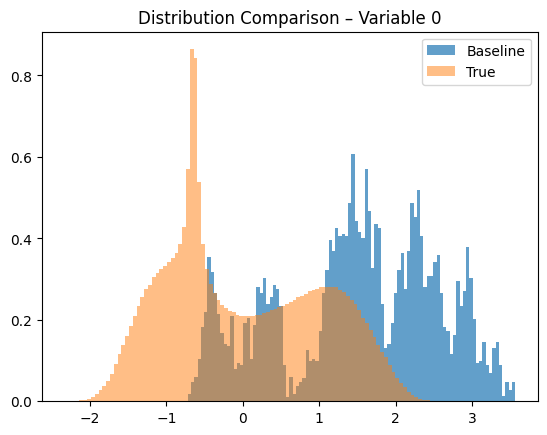

In [6]:
plt.hist(traj[:,0], bins=100, density=True, alpha=0.7, label="Baseline")
plt.hist(train_norm[...,0].flatten(), bins=100, density=True, alpha=0.5, label="True")
plt.legend()
plt.title("Distribution Comparison – Variable 0")
plt.show()


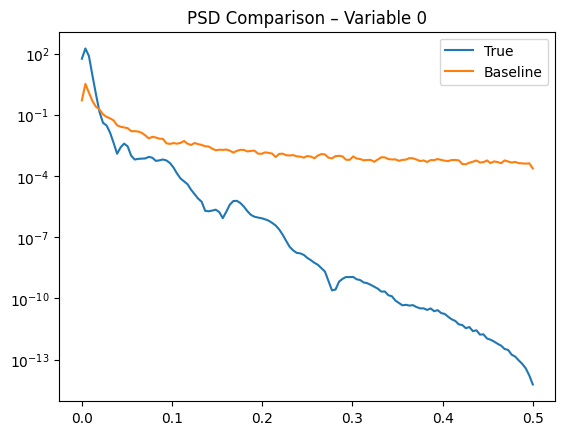

In [7]:
f_true, psd_true = welch(train_norm[0,:,0], nperseg=256)
f_base, psd_base = welch(traj[:,0], nperseg=256)

plt.semilogy(f_true, psd_true, label="True")
plt.semilogy(f_base, psd_base, label="Baseline")
plt.legend()
plt.title("PSD Comparison – Variable 0")
plt.show()


In [8]:
num_samples = test_norm.shape[0]
T_future = 5000

predictions = np.zeros((num_samples, 5100, 11))

for i in range(num_samples):
    history = test_norm[i]
    predictions[i, :100] = history

    rollout = persistence_rollout(
        history[-1],
        steps=T_future-1,
        noise_std=noise_std
    )

    predictions[i, 100:] = rollout


In [9]:
predictions = predictions * std + mean
np.save("../results/submission_baseline.npy", predictions)
